# Exploratory Data Analysis Notebook
This notebook will preprocess and leverage NLP models on the unstructured data to turn it into a usable feature space for modeling Tucker Carlson's body of work

In [5]:
#Imports cell

#Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import nltk
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# import the tucker document data either as a CSV or a pickle
#Read out from CSV
tucker_docs = pd.read_csv('data/tucker_docs.csv', encoding='UTF8', header = None).T
tucker_docs.head()

,0
0,Fox News host gives his take on pro-abortion ...
1,Fox News host reflects on the left's respons...
2,Fox News host gives his take on how Americans...
3,Fox News host gives his take on the Supreme C...
4,Fox News host gives his take on the real moti...


## preprocess function

In [8]:
#to stem or to lem? We will lem

wnl = WordNetLemmatizer()

def preprocessing(text):
    #step 1: delete all caps words
    t_d = re.sub(r'\b[A-Z]+\b', '', text)
    
    #step 2: tokenize
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenized_doc = nltk.regexp_tokenize(t_d, pattern)
    
    #step 3: lower all cases
    low_tokenized_doc = [word.lower() for word in tokenized_doc]
    
    #step 4: stop words
    stopwords_list = stopwords.words('english')
    stop_tokenized_doc = [word for word in low_tokenized_doc if word not in stopwords_list]
    
    #step 5: lem
    tokens = [wnl.lemmatize(word) for word in stop_tokenized_doc]
    
    return tokens

In [9]:
#Generate list of preprocessed Tucker Carlson episodes
tucker_list = tucker_docs[0].tolist()
new_list = []
for each_doc in tucker_list:
    new_list.append(preprocessing(each_doc))

In [10]:
#Instantiate IDF vectorizer to create vectorized array

vectorizer = TfidfVectorizer()
vect = vectorizer.fit_transform([' '.join(new_list[n]) for n in range(len(new_list))])
td_idf_df = pd.DataFrame(vect.toarray(), columns = vectorizer.get_feature_names())
td_idf_df.head()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,ab,abaca,aback,abandon,abandoned,abandoning,abandonment,abasement,abbott,...,zoomcall,zoomed,zoonotic,zot,zucker,zuckerberg,zuckerbucks,zvfcgesbfiy,zweig,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#Fit the NMF topic generation model
from sklearn.decomposition import NMF
model = NMF(n_components = 10)
model.fit(td_idf_df)

# to get H
H = model.transform(td_idf_df) # transform document into topic vector representation

# to get W 
W = model.components_ # word component weights for each topic

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [188]:
#List out the top 10 words for each topic

for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['thing', 'year', 'see', 'new', 'state', 'would', 'yes', 'say', 'mean', 'want', 'get', 'thank', 'country', 'one', 'like', 'well', 'right', 'they', 'think', 'going', 'know', 'we', 'that', 're', 'people']


THE TOP 10 WORDS FOR TOPIC #1
['that', 'they', 'american', 'military', 'going', 'biden', 'sanction', 'would', 'weapon', 'nuclear', 'know', 'united', 'invasion', 'energy', 'president', 'state', 'we', 're', 'vladimir', 'ukrainian', 'war', 'putin', 'russian', 'russia', 'ukraine']


THE TOP 10 WORDS FOR TOPIC #2
['function', 'gain', 'boogeyman', 'really', 'lab', 'said', 'look', 'wuhan', 'people', 'celebrate', 'public', 'infection', 'know', 'science', 'virus', 'scientist', 'pandemic', 'immunity', 'research', 'anthony', 'email', 'dr', 'christmas', 'tony', 'fauci']


THE TOP 10 WORDS FOR TOPIC #3
['mandate', 'crime', 'terrorism', 'biden', 'justice', 'violence', 'department', 'teach', 'education', 'terrorist', 'people', 'like', 'meeting', 're', 'they', 'domestic'

In [193]:
#Visualize the 10 topics

%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title, n_topics):
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model", 10)

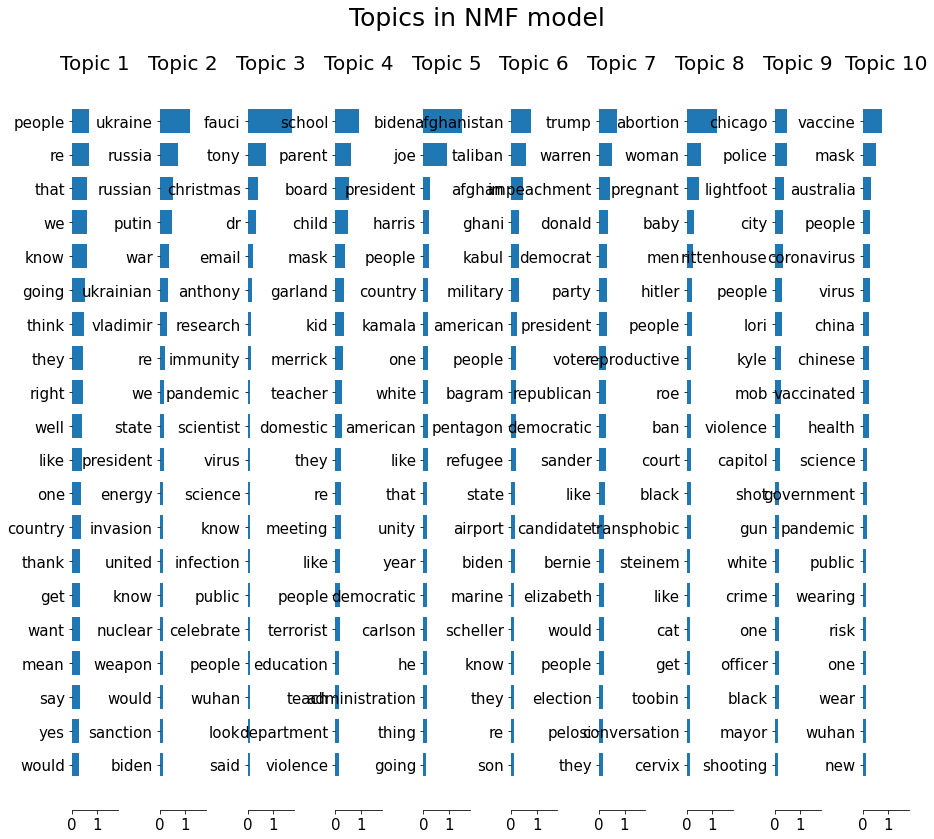

In [194]:
topic_word_plot()

In [86]:
#Manually re-assign topics
topic = {0: 'American Politics', 1: 'War in Ukraine', 2: 'Covid-19', 3: 'School', 4: 'Biden Administration', 
         5: 'War in Afghanistan', 6: 'Trump', 7: 'Abortion', 8: 'Kyle Rittenhouse Shooting', 
         9: 'Covid-19 Vaccine' }

## Preprocess the twitter data

In [26]:
tweet_df = pd.read_csv('data/unique_tweets_list.csv').drop(columns = ['Unnamed: 0'])

In [32]:
#Function library
import ast

def string_to_list(s):
    try:
        l = ast.literal_eval(s)
    except:
        l = None
    return l

In [33]:
def prepare_tweets(tweet_row):
    tweet_list = []
    for n in range(len(tweet_row)):
        tweet_list.append(preprocessing(tweet_row[n]))

    cleaned_tweets = []
    for tweet in tweet_list:
        if len(tweet) > 20:
            cleaned_tweets.append(tweet)
    return cleaned_tweets

In [28]:
#Preprocess each user's tweet history
tweet_df['tweet_history'] = tweet_df['tweet_history'].apply(lambda x: string_to_list(x))
tweet_df = tweet_df.dropna()
tweet_df['cleaned_tweets'] = tweet_df['tweet_history'].apply(lambda x: prepare_tweets(x))

In [29]:
tweet_df

,tweet_history,cleaned_tweets
0,"[""Legislative genius"" Nancy @TeamPelosi needs ...","[[imagine, female, journos, stay, twitter, mus..."
1,[withoutrunes: wack-ashimself: withoutrunes: w...,"[[withoutrunes, wack, ashimself, withoutrunes,..."
2,[Was just sent this after complaining about de...,"[[hahahahaha, omg, first, javascript, course, ..."
3,[Over turn Roe V Wade fine but be prepared to ...,"[[forget, roe, wade, law, need, made, amendmen..."
4,[@KealanBurke Some books I love so much I keep...,"[[kealanburke, book, love, much, keep, forever..."
...,...,...
3655,"[If anyone wants to try it for themselves, her...","[[tried, hand, traditional, venezuelan, staple..."
3656,[China‘s Uncontested Candidate ‘Wins‘ Hong Kon...,"[[reminder, abandoned, american, citizen, fami..."
3657,[RT @JRMajewski: How is he supposed to fight i...,"[[april, tucson, sector, border, patrol, agent..."
3658,[@kylejluebke Why haven’t you commented on the...,"[[starmedcare, actually, two, quick, question,..."


exact copy of twitter processing

In [42]:
def twitter_preprocessing(text):

    #Step 0
    #This is Praveen's code
    text = text.lower()
    text = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+@[A-Z0-9_]+|#[A-Z0-9_]+|http\S+", "", text).strip().replace("\r", "").replace("\n", "").replace("\t", "")
   
    #step 1: delete all caps words
    t_d = re.sub(r'\b[A-Z]+\b', '', text)

    #step 2: tokenize
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenized_doc = nltk.regexp_tokenize(t_d, pattern)

    #step 3: stop words
    stopwords_list = stopwords.words('english')
    stop_tokenized_doc = [word for word in tokenized_doc if word not in stopwords_list]

    #step 4: lem
    tokens = [wnl.lemmatize(word) for word in stop_tokenized_doc]
    return ' '.join(tokens)

In [43]:
tweet_df = pd.read_csv('data/unique_tweets_list.csv').drop(columns = ['Unnamed: 0'])

In [44]:
import ast

len(ast.literal_eval(tweet_df.iloc[750,:][0]))

100

In [45]:
def string_to_list(s):
    try:
        l = ast.literal_eval(s)
    except:
        l = None
    return l

In [46]:
tweet_df['tweet_history'] = tweet_df['tweet_history'].apply(lambda x: string_to_list(x))

In [47]:
tweet_df = tweet_df.dropna()

In [48]:
def prepare_tweets(tweet_row):
    tweet_list = []
    for n in range(len(tweet_row)):
        tweet_list.append(twitter_preprocessing(tweet_row[n]))

    cleaned_tweets = []
    for tweet in tweet_list:
        if len(tweet) > 20:
            cleaned_tweets.append(tweet)
    return cleaned_tweets

In [49]:
tweet_df['cleaned_tweets'] = tweet_df['tweet_history'].apply(lambda x: prepare_tweets(x))

In [52]:
tweet_df['vectorized'] = tweet_df['cleaned_tweets'].apply(lambda x: vectorizer.transform(x))

In [55]:

model.transform()

<95x23434 sparse matrix of type '<class 'numpy.float64'>'
	with 1480 stored elements in Compressed Sparse Row format>

In [108]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3658 entries, 0 to 3659
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_history   3658 non-null   object
 1   cleaned_tweets  3658 non-null   object
 2   vectorized      3658 non-null   object
dtypes: object(3)
memory usage: 243.4+ KB


In [109]:
#Fit the NMF topic generation model

# to get H
H_list = []

for n in range(len(tweet_df)):
    try:
        H_list.append(model.transform(tweet_df['vectorized'][n])) # transform document into topic vector representation
    except:
        continue;

# to get W 
#W = model.components_ # word component weights for each topic

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-p

In [135]:
#List out the top 10 words for each topic
topic_weights = []

for n in range(0, len(tweet_df) - 2):
    topic_weights.append(list(pd.DataFrame(H_list[n], columns = list(topic.values())).sum()))

In [139]:
relative_weights_df = pd.DataFrame(topic_weights,  columns = list(topic.values()))

In [177]:
relative_weights_df

,American Politics,War in Ukraine,Covid-19,School,Biden Administration,War in Afghanistan,Trump,Abortion,Kyle Rittenhouse Shooting,Covid-19 Vaccine
0,0.640168,0.251760,0.116983,0.725051,0.367564,0.248937,0.994627,0.513925,0.220415,0.198069
1,0.950830,0.109965,0.083227,0.221081,0.234946,0.233517,0.337763,1.140842,0.389943,0.326422
2,0.856408,0.115235,0.094130,0.241611,0.113578,0.143050,0.270207,1.188310,0.202054,0.131407
3,0.092673,0.040253,0.003840,0.044028,0.110658,0.045168,0.109475,0.282628,0.035146,0.055702
4,0.408809,0.224910,0.083976,0.205942,0.099762,0.107317,0.239651,1.394043,0.182643,0.103444
...,...,...,...,...,...,...,...,...,...,...
3651,0.986682,0.245144,0.150466,0.382112,0.253496,0.240142,0.305198,0.733107,0.125441,0.252409
3652,0.636656,1.203386,0.193340,0.101898,0.287642,0.072013,0.368975,0.650634,0.165757,0.081161
3653,0.507185,0.047209,0.043288,0.180377,0.091089,0.112279,0.181784,0.451634,0.168797,0.131524
3654,0.232049,0.390306,0.194996,0.236639,0.267923,0.244438,0.391146,0.784553,0.218439,0.299214


In [144]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(relative_weights_df)

KMeans(n_clusters=2)

In [149]:
tucker_not_tucker_maybe_we_will_see_soon_enough = pd.Series(kmeans.predict(relative_weights_df))

In [153]:
yay_we_did_a_model_df = pd.concat([relative_weights_df, tucker_not_tucker_maybe_we_will_see_soon_enough], axis = 1)

In [165]:
yay_we_did_a_model_df.iloc[:740,:][0].sort_values(ascending = False)

739    1
411    1
173    1
178    1
600    1
      ..
279    0
280    0
281    0
282    0
370    0
Name: 0, Length: 740, dtype: int32

In [179]:
#Generate tucker carlson distribution
model.transform(td_idf_df)[0]

array([0.08054672, 0.00193651, 0.        , 0.03390633, 0.0175186 ,
       0.        , 0.0042344 , 0.10341704, 0.        , 0.        ])